In [1]:
import pandas as pd
import numpy
import re
import json
import io
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [2]:
f_raw = '../static/data/death-and-co-raw-data.csv'
f_out_json = '../static/data/cocktails.json'

all_columns = ['row', 'page', 'name', 'ingredient', 'simple_ingredient', 'quantity', 'notes', 'empty', 'empty2']
drop_columns = ['row', 'page', 'notes', 'empty', 'empty2']

In [3]:
# Read file and drop unneeded columns
df_raw = pd.read_csv(f_raw)
df_raw.columns = all_columns
df_raw = df_raw.drop(drop_columns, 'columns')

In [4]:
df_raw.head(5)

,name,ingredient,simple_ingredient,quantity
0,NaN,NaN,NaN,NaN
1,20TH CENTURY,BEEFEATER LONDON DRY GIN,GIN (LONDON DRY),1.5
2,20TH CENTURY,MARIE BRIZARD WHITE CRÈME DE CACAO,LIQUEUR (CRÈME DE CACAO),0.75
3,20TH CENTURY,COCCHI AMERICANO,APERITIF (COCCHI AMERICANO),0.75
4,20TH CENTURY,LEMON JUICE,JUICE (LEMON),0.75


In [5]:
# Copy and drop null rows (these separate cocktails in raw csv)
df = df_raw.copy()
df = df.dropna(how='all')

In [6]:
df.head()

,name,ingredient,simple_ingredient,quantity
1,20TH CENTURY,BEEFEATER LONDON DRY GIN,GIN (LONDON DRY),1.5
2,20TH CENTURY,MARIE BRIZARD WHITE CRÈME DE CACAO,LIQUEUR (CRÈME DE CACAO),0.75
3,20TH CENTURY,COCCHI AMERICANO,APERITIF (COCCHI AMERICANO),0.75
4,20TH CENTURY,LEMON JUICE,JUICE (LEMON),0.75
6,AIRMAIL,RON DEL BARRILITO 3-STAR RUM,RUM (SPANISH),1


In [7]:
grouped_cocktails = df.groupby('name')

In [8]:
# matches 'SIMPLE SIMPLE (SPECIFIC (MORE SPECIFIC))' as 2 groups
name_regex = '([^\(\)]*)\((.*)\)'

# If a 'simple ingredient' appears in this list, we'll use its 'ingredient' instead
# for more meaningful clustering
use_ingredient_not_simple_ingredient = { 
    'JUICE': True, 
    'APERITIF': True, 
    'LIQUEUR': True, 
}

TOTAL_KEY = "__TOTAL"

In [61]:
SPIRITS = set(['RUM', 'VERMOUTH', 'GIN', 'BRANDY', 'AGAVE', 'VODKA', 'WHISKEY', 'SHERRY', 'ABSINTHE'])
def is_spirit(i):
    return i in SPIRITS

SECONDARY_ALCOHOL = set(['BEER', 'MADEIRA', 'WINE', 'PORT', 'CIDER', 'CHAMPAGNE'])
def is_secondary_alcohol(i):
    return i in SECONDARY_ALCOHOL

LIQUEURS = set(['CHARTREUSE', 'CACHAÇA', 'BRANDY', 'AMARO', 'BATAVIA ARRACK'])       
def is_liqueur(i):
    return i in LIQUEURS or \
        'LIQUEUR' in i or \
        'APERITIF' in i

GARNISHES = set(['LEAF', 'FRUIT', 'VEGETABLE', 'MINT', 'TWIST', 'MIX', 'SALT', 'RIM', 'SPICE'])
def is_garnish(i):
    return i in GARNISHES

SWEETENERS = set(['SYRUP', 'SUGAR', 'SUGAR CUBE', 'SODA', 'CORDIAL', 'SHRUB'])
def is_sweetener(i):
    return i in SWEETENERS or \
        'JUICE' in i

all_category_mappings = {}

def get_category_from_ingredient(ingredient):
    category = 'OTHER'
    
    if is_spirit(ingredient):
        category = 'SPIRIT'
    elif is_liqueur(ingredient):
        category = 'LIQUEUR'
    elif is_secondary_alcohol(ingredient):
        category = 'ALCOHOL'
    elif is_sweetener(ingredient):
        category = 'SWEET'
    elif is_garnish(ingredient):
        category = 'GARNISH'
        
    if category not in all_category_mappings:
        all_category_mappings[category] = {}
    
    if ingredient not in all_category_mappings[category]:
        all_category_mappings[category][ingredient] = 0
    
    all_category_mappings[category][ingredient] += 1
        
    return category

In [62]:
cocktails = {}

# use dicts to track counts
ingredients = {}
simple_ingredients = {}
verbose_ingredients = {}

for cocktail in grouped_cocktails.groups:
    group = grouped_cocktails.get_group(cocktail)
    
    cocktail_ingredients = { TOTAL_KEY: 0 }
    
    for i, item in group.iterrows():
        verbose_ingredient = item[1]
        ingredient = item[2]
        
        if pd.isna(ingredient): 
            continue

        ingredient_match = re.match(name_regex, ingredient)
        simple_ingredient = ingredient_match.group(1) if ingredient_match else ingredient
        simple_ingredient = simple_ingredient.strip()
        
        if simple_ingredient in use_ingredient_not_simple_ingredient:
            simple_ingredient = ingredient
        
        try:
            quantity = float(item[3])
        except:
            
            try:
                quantity = float(item[3].split(' ')[0])
#                 print('non-float quantity', item[3], 'using', quantity)
            
            except:
#                 print('non-float quantity', item[3], 'falling back to 1')
                quantity = 1
           
        # default to 1
        if numpy.isnan(quantity):
#             print('nan quantity', group)
            quantity = 0.5

        # convert Fruit/Leaves to 0.5 so as not to throw off
        if simple_ingredient == 'FRUIT' or simple_ingredient == 'LEAF':
            quantity = 0.5
        
        if simple_ingredient == 'APÉRITIF' or simple_ingredient == 'APPERITIF':
            simple_ingredient = 'APERITIF'
        
        ingredient_obj = { 
            'cocktail': cocktail.lower(),
            'ingredient': ingredient.lower(),
            'simple_ingredient': simple_ingredient.lower(), 
            'verbose_ingredient': verbose_ingredient.lower(), 
            'quantity': quantity,
            'category': get_category_from_ingredient(simple_ingredient).lower(),
        }
        
        cocktail_ingredients[TOTAL_KEY] += quantity
        
        # key on most specific ingredient to ensure uniqueness        
        cocktail_ingredients[verbose_ingredient] = ingredient_obj
        
        # update ingredient counts
        if ingredient not in ingredients: 
            ingredients[ingredient] = 0
            
        if simple_ingredient not in simple_ingredients: 
            simple_ingredients[simple_ingredient] = 0
            
        if verbose_ingredient not in verbose_ingredients: 
            verbose_ingredients[verbose_ingredient] = 0
            
        ingredients[ingredient] += 1
        simple_ingredients[simple_ingredient] += 1
        verbose_ingredients[verbose_ingredient] += 1
    
    del cocktail_ingredients[TOTAL_KEY]
    
    cocktails[cocktail.lower()] = cocktail_ingredients

# print(json.dumps(all_category_mappings, indent=4))

In [63]:
# write output file
f_out = io.open(f_out_json, 'w')
json.dump(cocktails, f_out, indent=2)
f_out.close()

In [13]:
'test' in 'blahtestasdfg'

True

In [12]:
# Print ingredients by count
simple_ingredients_list = sorted(
    list(simple_ingredients.keys()), 
    key=lambda name: -simple_ingredients[name],
)

print(
    sorted(
        simple_ingredients.items(),
        key=lambda item: -item[1],
    )
)

[('SYRUP', 708), ('BITTERS', 512), ('RUM', 288), ('JUICE (LEMON)', 268), ('VERMOUTH', 258), ('WHISKEY', 252), ('GIN', 252), ('JUICE (LIME)', 228), ('AGAVE', 210), ('BRANDY', 208), ('AMARO', 158), ('WINE', 110), ('SHERRY', 92), ('SODA', 88), ('FRUIT', 78), ('LIQUEUR (ORANGE)', 74), ('ABSINTHE', 70), ('CHARTREUSE', 70), ('TWIST', 64), ('LIQUEUR (CHERRY)', 62), ('JUICE (PINEAPPLE)', 58), ('JUICE (GRAPEFRUIT)', 58), ('LIQUEUR (ELDERFLOWER)', 46), ('OTHER', 42), ('SUGAR CUBE', 40), ('EGG', 38), ('LIQUEUR (BÉNÉDICTINE)', 38), ('JUICE (ORANGE)', 34), ('MIX', 34), ('LIQUEUR (CRÈME DE CACAO)', 32), ('CREAM', 32), ('MINT', 26), ('SALT', 26), ('LIQUEUR (FALERNUM)', 26), ('LIQUEUR (CARAWAY) (AQUAVIT)', 24), ('JUICE (APPLE)', 22), ('BATAVIA ARRACK', 20), ('APPERITIF', 18), ('APERITIF (COCCHI AMERICANO)', 18), ('LIQUEUR (PEACH)', 18), ('LEAF', 18), ('VEGETABLE', 18), ('CHERRY HEERING', 16), ('LIQUEUR (GALLIANO)', 16), ('LIQUEUR (ALLSPICE DRAM)', 14), ('LIQUEUR (CRÈME YVETTE)', 12), ('LIQUEUR (DRAMBU

NameError: name 'SYRUP' is not defined

In [75]:
# give ingredients with lower frequency, higher weight 
# (rare ingredients should be counted higher in a match)
# this yields weights of 5-10
max_simple_ingredient_count = max(list(simple_ingredients.values()))
get_simple_ingredient_weight = lambda count: 5 * (1 - count/max_simple_ingredient_count + 1)

df_ingredient_counts = pd.DataFrame({ 
    'ingredient': list(simple_ingredients.keys()), 
    'count': list(simple_ingredients.values()), 
    'weight': list(map(get_simple_ingredient_weight, list(simple_ingredients.values()))),
}, index=list(simple_ingredients.keys()))

# df_ingredient_counts.sort_values('weight', ascending=True, inplace=True)

# df_ingredient_counts.head(15)

In [76]:
bitters_weight = 7.5 # bitters has low volume, weight it higher

In [77]:
# should weigh the matrices by ingredient
simple_ingredient_weights = numpy.array(
    list(
        map(
            lambda x: bitters_weight if x == 'BITTERS' \
                else get_simple_ingredient_weight(simple_ingredients[x]), 
            
            simple_ingredients.keys(),
        ),
    ),
)


In [78]:
max_ingredient_count = max(list(ingredients.values()))
get_ingredient_weight = lambda count: 5 * (1 - count/max_ingredient_count + 1)

ingredient_weights = numpy.array(
    list(
        map(
            lambda x: bitters_weight if x == 'BITTERS' \
                else get_ingredient_weight(ingredients[x]), 
            
            ingredients.keys(),
        ),
    ),
)

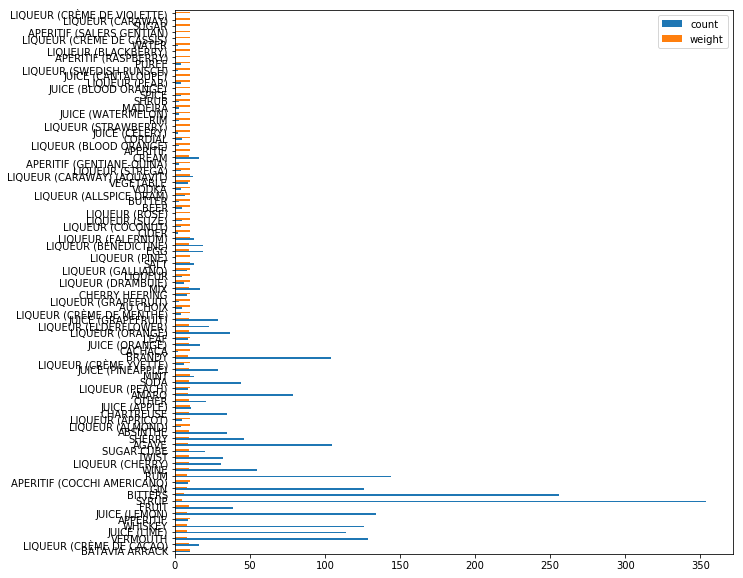

In [45]:
df_ingredient_counts.plot.barh(figsize=(10, 10))

In [46]:
print('''
{} simple ingredients 
{} ingredients 
{} verbose ingredients 
{} cocktails 
'''.format(
    len(simple_ingredients), 
    len(ingredients),
    len(verbose_ingredients), 
    len(cocktails),
))


87 simple ingredients 
222 ingredients 
451 verbose ingredients 
486 cocktails 



In [48]:
simple_ingredients

{'BATAVIA ARRACK': 10,
 'LIQUEUR (CRÈME DE CACAO)': 16,
 'VERMOUTH': 129,
 'JUICE (LIME)': 114,
 'WHISKEY': 126,
 'APPERITIF': 9,
 'JUICE (LEMON)': 134,
 'FRUIT': 39,
 'SYRUP': 354,
 'BITTERS': 256,
 'GIN': 126,
 'APERITIF (COCCHI AMERICANO)': 9,
 'RUM': 144,
 'WINE': 55,
 'LIQUEUR (CHERRY)': 31,
 'TWIST': 32,
 'SUGAR CUBE': 20,
 'AGAVE': 105,
 'SHERRY': 46,
 'ABSINTHE': 35,
 'LIQUEUR (ALMOND)': 4,
 'LIQUEUR (APRICOT)': 5,
 'CHARTREUSE': 35,
 'JUICE (APPLE)': 11,
 'OTHER': 21,
 'AMARO': 79,
 'LIQUEUR (PEACH)': 9,
 'SODA': 44,
 'MINT': 13,
 'JUICE (PINEAPPLE)': 29,
 'LIQUEUR (CRÈME YVETTE)': 6,
 'BRANDY': 104,
 'CACHAÇA': 2,
 'JUICE (ORANGE)': 17,
 'LEAF': 9,
 'LIQUEUR (ORANGE)': 37,
 'LIQUEUR (ELDERFLOWER)': 23,
 'JUICE (GRAPEFRUIT)': 29,
 'LIQUEUR (CRÈME DE MENTHE)': 4,
 'AU CHOIX': 5,
 'LIQUEUR (GRAPEFRUIT)': 3,
 'CHERRY HEERING': 8,
 'MIX': 17,
 'LIQUEUR (DRAMBUIE)': 6,
 'LIQUEUR': 5,
 'LIQUEUR (GALLIANO)': 8,
 'SALT': 13,
 'LIQUEUR (PINE)': 1,
 'EGG': 19,
 'LIQUEUR (BÉNÉDICTINE)': 

In [47]:
ingredients

{'BATAVIA ARRACK': 10,
 'LIQUEUR (CRÈME DE CACAO)': 16,
 'VERMOUTH (SWEET)': 83,
 'JUICE (LIME)': 114,
 'WHISKEY (BOURBON)': 34,
 'APPERITIF (LILLET ROUGE)': 2,
 'JUICE (LEMON)': 134,
 'FRUIT (TANGERINE)': 1,
 'SYRUP (SIMPLE)': 75,
 'BITTERS (ORANGE)': 41,
 'GIN (LONDON DRY)': 55,
 'APERITIF (COCCHI AMERICANO)': 9,
 'RUM (AGRICOLE BLANC)': 17,
 'SYRUP (CANE SUGAR)': 59,
 'BITTERS (AROMATIC)': 129,
 'RUM (SPANISH)': 34,
 'SYRUP (HONEY)': 34,
 'WINE (SPARKLING)': 40,
 'LIQUEUR (CHERRY)': 31,
 'TWIST (LEMON)': 18,
 'FRUIT (STRAWBERRY)': 9,
 'SUGAR CUBE': 20,
 'AGAVE (TEQUILA BLANCO)': 43,
 'SHERRY': 17,
 'ABSINTHE': 35,
 'GIN (GENEVER)': 12,
 'SYRUP (DEMERARA)': 31,
 'BITTERS (CREOLE)': 38,
 'AGAVE (TEQUILA REPOSADO)': 31,
 'LIQUEUR (ALMOND)': 4,
 'LIQUEUR (APRICOT)': 5,
 'SYRUP (ORGEAT)': 27,
 'SYRUP (MAPLE)': 14,
 'VERMOUTH (BLANC)': 22,
 'CHARTREUSE (YELLOW)': 22,
 'SYRUP (CINNAMON)': 28,
 'RUM (ENGLISH WHITE)': 4,
 'JUICE (APPLE)': 11,
 'SYRUP (VANILLA)': 22,
 'OTHER (ACID PHOSPHATE)'

In [75]:
# verbose_ingredients

In [145]:
# create the (cocktail x ingredient) matrices

# create 2 simple ingredient matrices, for binary + quantities
simple_ingredient_quant_matrix = numpy.zeros(shape=(len(simple_ingredients), len(cocktails)))
simple_ingredient_binary_matrix = numpy.zeros(shape=(len(simple_ingredients), len(cocktails)))

# create 2 ingredient matrices, for binary + quantities
ingredient_quant_matrix = numpy.zeros(shape=(len(ingredients), len(cocktails)))
ingredient_binary_matrix = numpy.zeros(shape=(len(ingredients), len(cocktails)))



cocktail_index = 0

for cocktail, cocktail_ingredients in cocktails.items():
    sum_ingredient = {}
    sum_simple = {}
    cocktail_total_quantity = cocktail_ingredients[TOTAL_KEY]
    
    # because one cocktail may contain muliple entries for
    # "ingredient" and "simple_ingredient", sum quantities of duplicate keys
    for verbose_key, current_ingredient in cocktail_ingredients.items():
        if verbose_key == TOTAL_KEY: 
            continue
        
        ingredient = current_ingredient['ingredient']
        simple_ingredient = current_ingredient['simple_ingredient']
        quantity = current_ingredient['quantity']
        
        if numpy.isnan(quantity):
            print('nan', current_ingredient)
            
        if ingredient not in sum_ingredient:
            sum_ingredient[ingredient] = 0
            
        if simple_ingredient not in sum_simple:
            sum_simple[simple_ingredient] = 0
        
        sum_ingredient[ingredient] += quantity
        sum_simple[simple_ingredient] += quantity
        
        # print(sum_simple)
    
    # now iterate over ingredient lists and update binary + quant matrices
    for index, ingredient in enumerate(ingredients):
        if ingredient in sum_ingredient:
            
            normalized_quant = sum_ingredient[ingredient] / cocktail_total_quantity
            
            ingredient_quant_matrix[index][cocktail_index] += normalized_quant
            ingredient_binary_matrix[index][cocktail_index] = 1

        
    for index, simple_ingredient in enumerate(simple_ingredients):
        if simple_ingredient in sum_simple:
            
            normalized_quant = sum_simple[simple_ingredient] / cocktail_total_quantity
            
            simple_ingredient_quant_matrix[index][cocktail_index] += normalized_quant
            simple_ingredient_binary_matrix[index][cocktail_index] = 1

    cocktail_index += 1
    
#     if cocktail_index >= 10:
#         break

In [84]:
# Based off these dims
# num_cocktails = 10
# num_ingredients = 3

# mat = numpy.ones(shape=[num_ingredients, num_cocktails])
# weights = numpy.array([0, 0 ,0]) 

# mat.T * weights

In [85]:
# if we were weighting ingredients
# final_cocktail_simple_matrix = simple_ingredient_weights[:, numpy.newaxis] * cocktail_simple_ingredient_matrix
# final_cocktail_ingredient_matrix = ingredient_weights[:, numpy.newaxis]  * cocktail_ingredient_matrix

In [110]:
#??scipy.cluster.hierarchy.linkage
simple_ingredient_binary_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

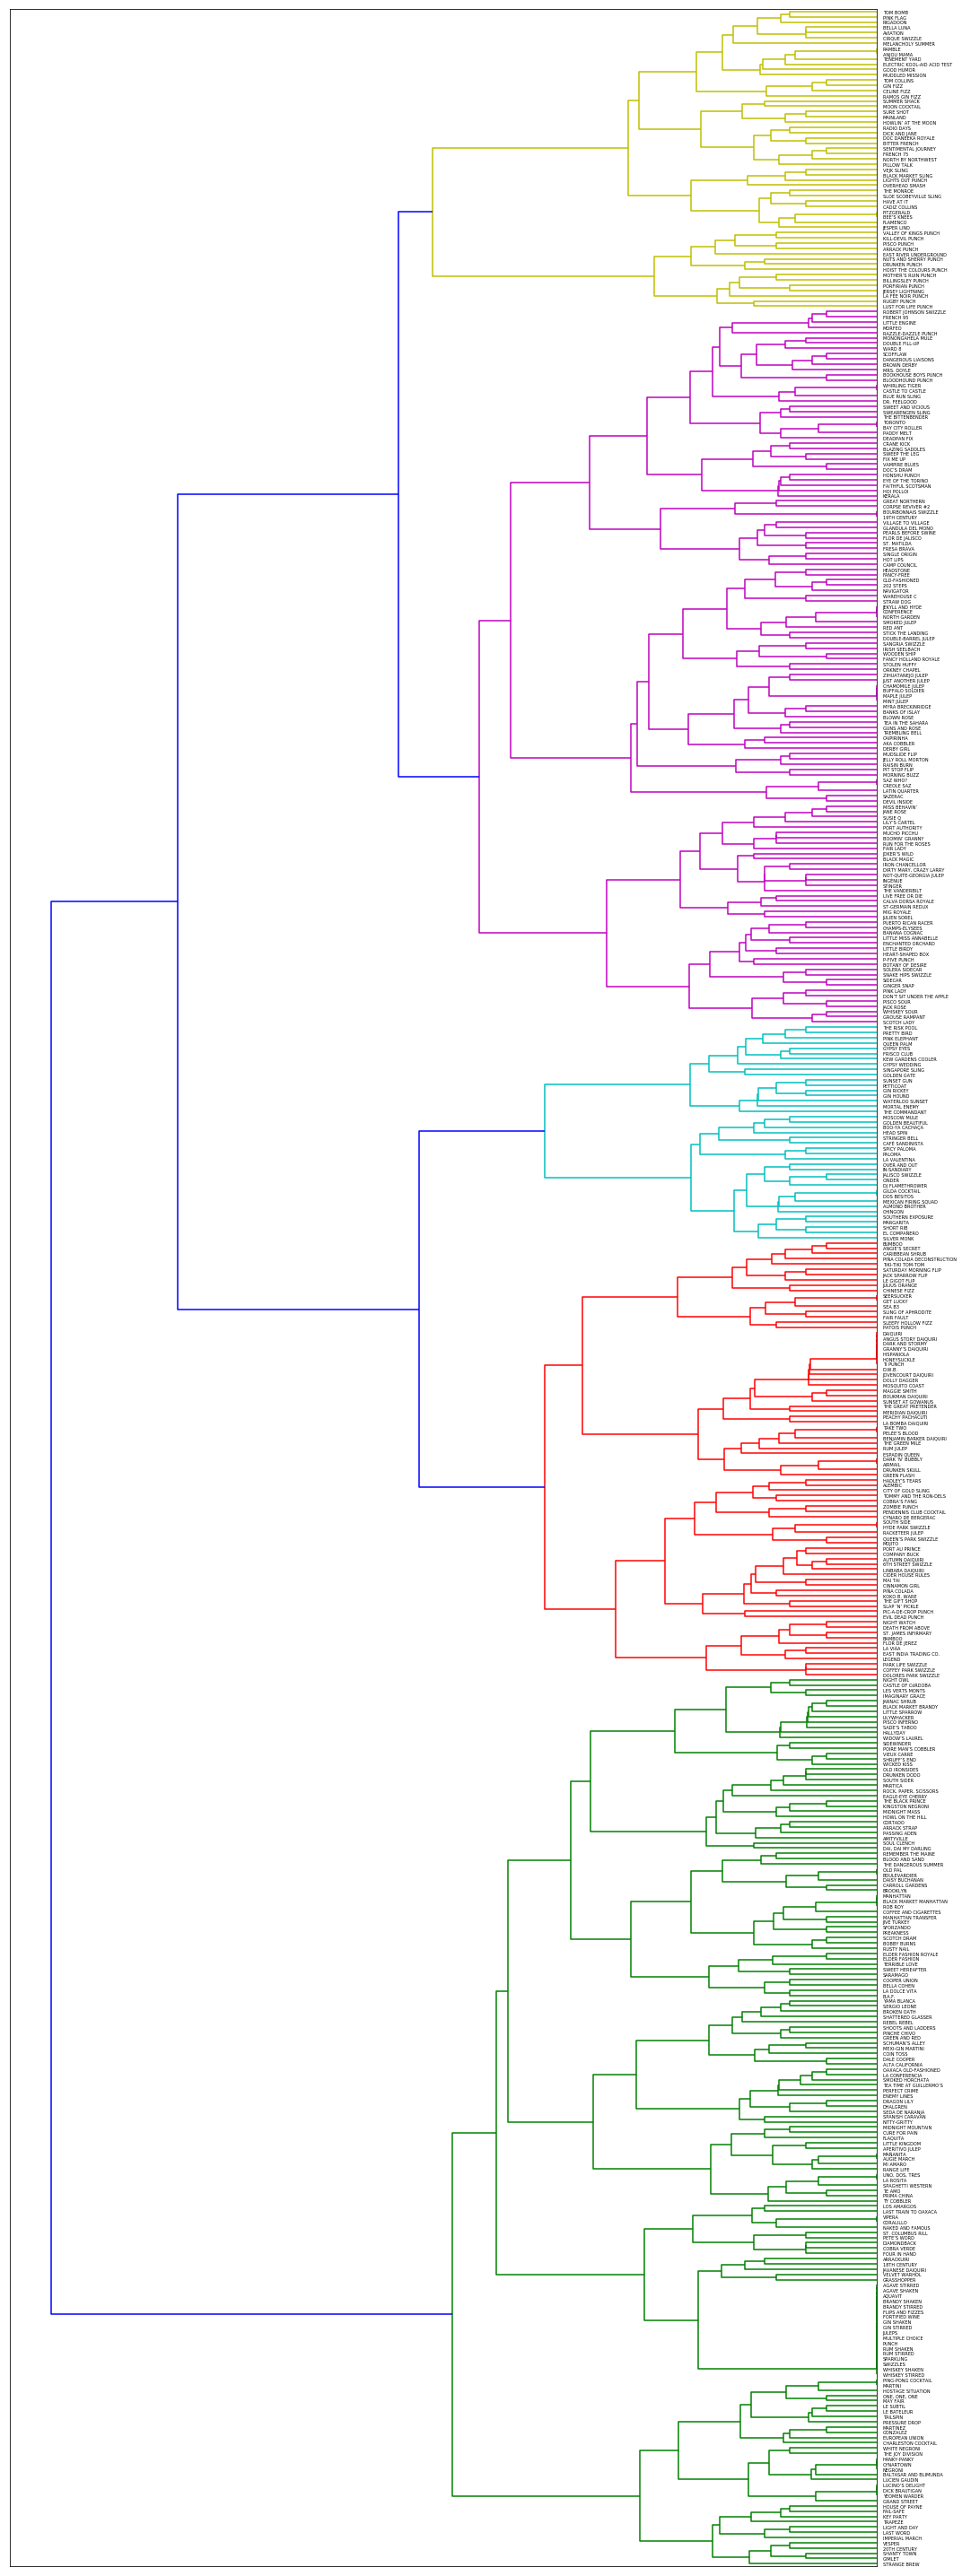

In [148]:
# define the linkage_matrix using ward clustering pre-computed distances
simple_binary_linkage_matrix = ward(numpy.rot90(simple_ingredient_binary_matrix, 3)) 

fig, ax = plt.subplots(figsize=(15, 40)) # set size
ax = dendrogram(\
    simple_binary_linkage_matrix, 
    orientation='left', 
    labels=list(cocktails),
    color_threshold=8,
)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tight_layout() #show plot with tight layout
plt.savefig('cocktail-families-simple-binary.pdf', dpi=300) #save figure as ward_clusters

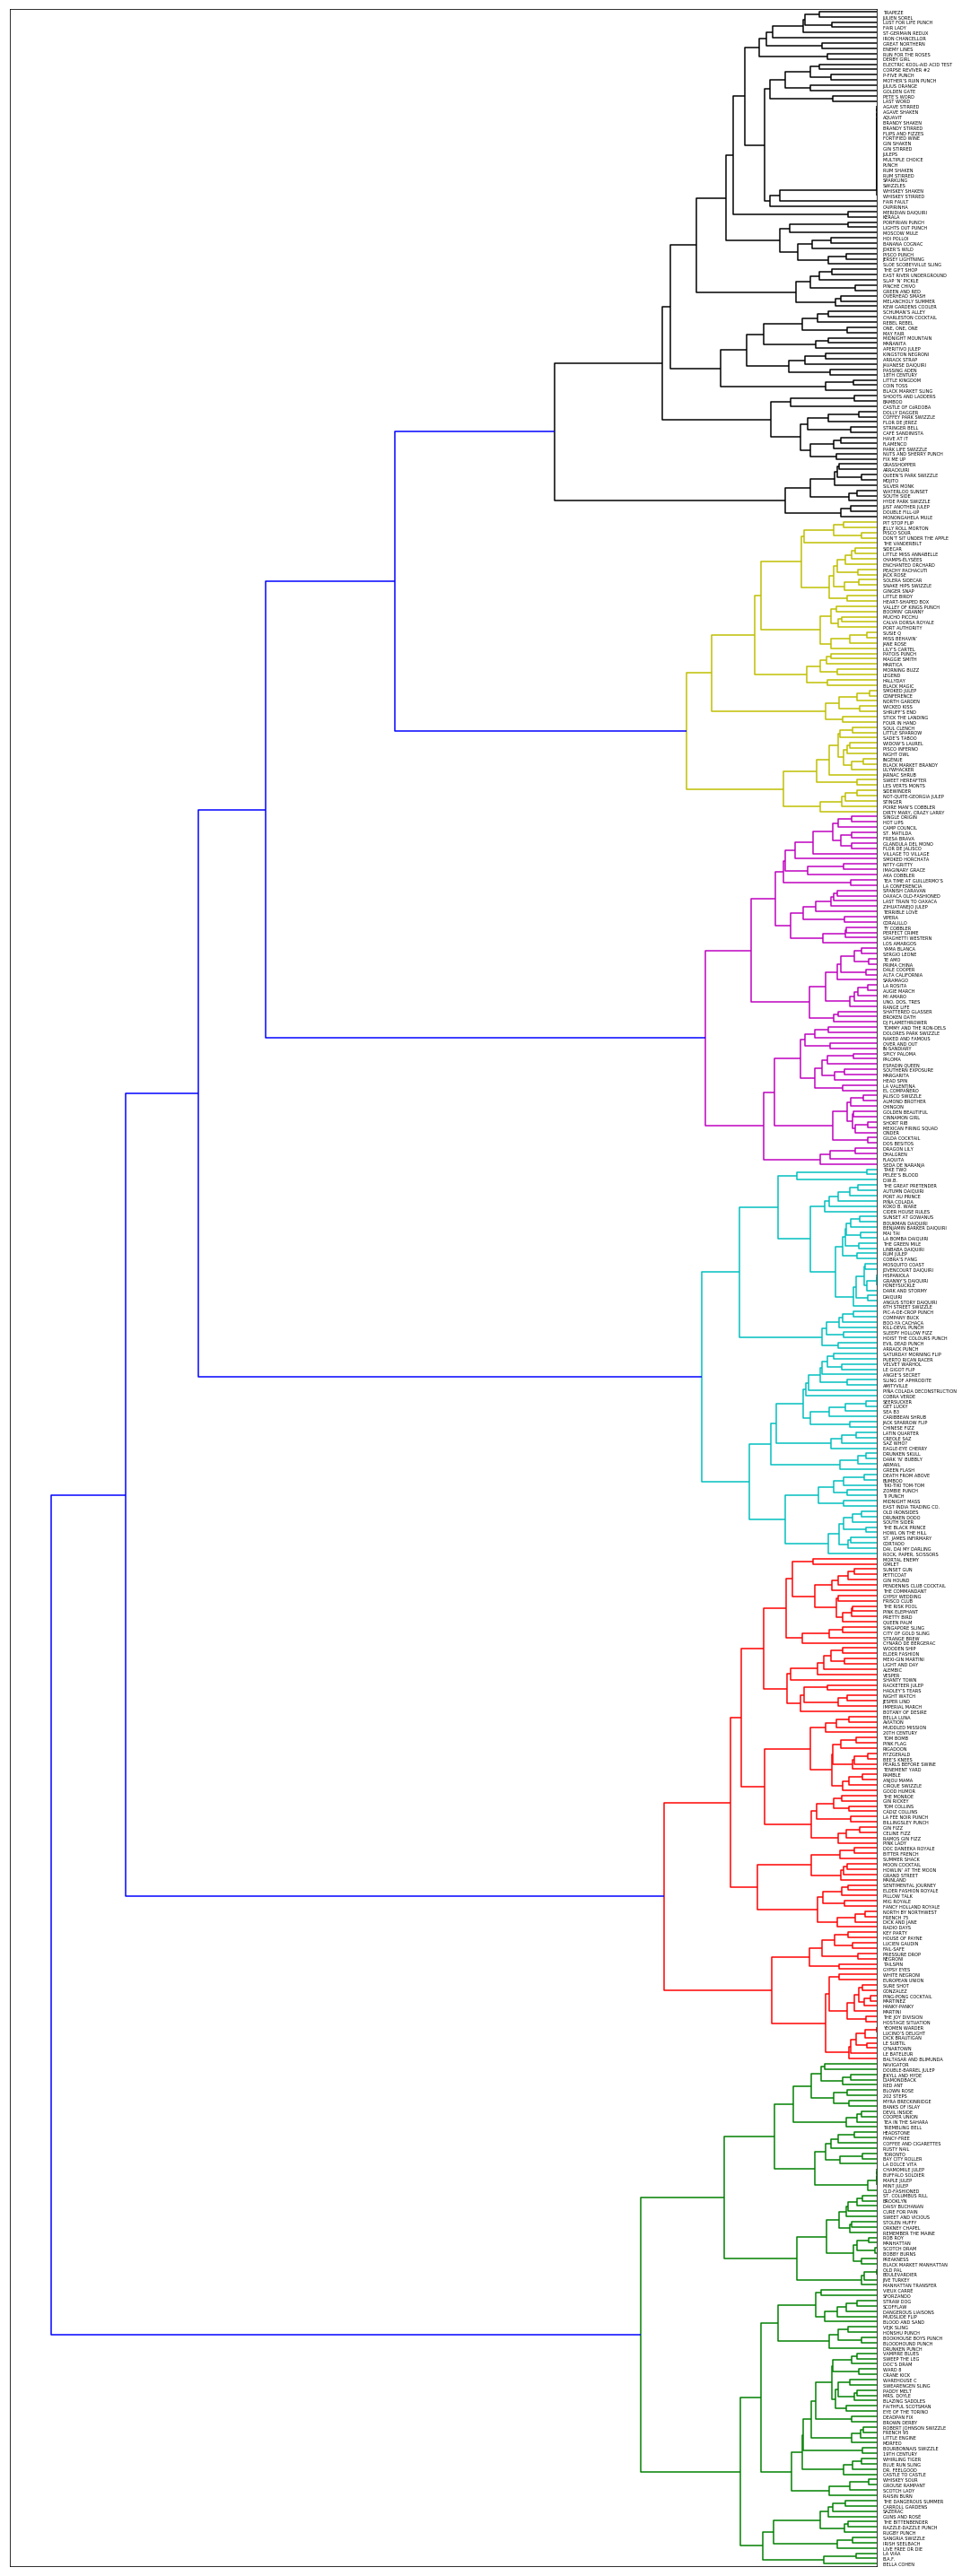

In [130]:
# define the linkage_matrix using ward clustering pre-computed distances
simple_quant_linkage_matrix = ward(numpy.rot90(simple_ingredient_quant_matrix, 3)) 

fig, ax = plt.subplots(figsize=(15, 40)) # set size
ax = dendrogram(\
    simple_quant_linkage_matrix, 
    orientation='left', 
    labels=list(cocktails),
    color_threshold=3,
)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tight_layout() #show plot with tight layout
plt.savefig('cocktail-families-simple-quant.pdf', dpi=300) #save figure as ward_clusters

In [56]:
# spot checks
def print_ingredients(cocktail_names, cocktails, keys=['simple_ingredient']):
    for cocktail_name in cocktail_names:
        try:
            cocktail = cocktails[cocktail_name]

        except:
            print('❌cockail not found {}'.format(cocktail_name))
            return

        quantity_sum = cocktail[TOTAL_KEY]
        print('🍹{} (total quantity({:.2f}))'.format(cocktail_name, quantity_sum))

        for key in keys:
            print('🧪 {}'.format(key))

            for ingred in cocktail.values():
                if type(ingred) != float and type(ingred) != int:
                    print('{} {:.3f} weighted({:.3f})'.format(ingred[key], ingred['quantity'], ingred['quantity'] / quantity_sum))
    
            print('')
        print('')

In [144]:
a = ['OLD-FASHIONED', 'MINT JULEP']
b = ['COMPANY BUCK', 'PIÑA COLADA']
c = ['BOO-YA CACHAÇA', 'GREEN FLASH']
d = ['GIN STIRRED', 'GIN SHAKEN']
e = ['LA ROSITA', 'AUGIE MARCH']

# gin
f = ['NEGRONI', 'TAILSPIN', 'PRESSURE DROP']

# whiskey
g = ['FRENCH 75', 'FRENCH 95', 'ROBERT JOHNSON SWIZZLE', 'LITTLE ENGINE']

# whiskey vermouth
h = ['SAZERAC', 'GUNS AND ROSÉ']
i = ['BOULEVARDIER', 'OLD PAL', 'JIVE TURKEY']
j = ['ST. COLUMBUS RILL', 'BROOKLYN', 'PREAKNESS']

# rum
k = ['MAI TAI', 'RUM JULEP', 'PIÑA COLADA', 'DAIQUIRI']

# agave
l = ['PALOMA', 'MARGARITA']

# brandy
m = ['SIDECAR', 'PISCO SOUR']

# fruit 
n = ['GYPSY WEDDING', 'DERBY GIRL']

# 
o = ['18TH CENTURY', 'MOSCOW MULE']


print_ingredients(
    ['MARGARITA', 'SHORT RIB'], 
    cocktails, 
    ['simple_ingredient'],
#     ['ingredient'],
)
print('')

🍹MARGARITA (total quantity(4.50))
🧪 simple_ingredient
SALT 0.500 weighted(0.111)
AGAVE 2.000 weighted(0.444)
LIQUEUR (ORANGE) 0.750 weighted(0.167)
JUICE (LIME) 1.000 weighted(0.222)
SYRUP 0.250 weighted(0.056)


🍹SHORT RIB (total quantity(3.88))
🧪 simple_ingredient
AGAVE 2.000 weighted(0.516)
JUICE (LIME) 0.750 weighted(0.194)
SYRUP 1.000 weighted(0.258)
OTHER 0.125 weighted(0.032)





🍹BOULEVARDIER
sum = 3.0
WHISKEY 1.500 weighted(0.500)
VERMOUTH 0.750 weighted(0.250)
AMARO 0.750 weighted(0.250)

🍹JIVE TURKEY
sum = 3.53125
WHISKEY 1.000 weighted(0.283)
WHISKEY 0.750 weighted(0.212)
AMARO 0.750 weighted(0.212)
VERMOUTH 0.750 weighted(0.212)
LIQUEUR 0.250 weighted(0.071)
BITTERS 0.031 weighted(0.009)
